In [809]:
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
import random

import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.datasets as dset

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [810]:
n_epochs = 100
batch_size = 64
lr = 1e-4
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 10
img_size = 64
channels = 3
sample_interval=400
lam1 = 1e-1
lam2 = 1e-2
sample_pixels = sorted(random.sample(list(range(img_size*img_size*3)), 6500))

img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

In [811]:
dataroot = "resized_data_bayc_no_background"
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [812]:
samples = 5000
image_samples = np.zeros((samples, img_size*img_size*3))
for i in range(0, samples):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, _ = dataset[sample_idx]
    flat = torch.flatten(img).numpy()
    image_samples[i] = flat
image_samples_apes = image_samples.T[sample_pixels]
image_samples_apes = torch.tensor(image_samples_apes)

In [813]:
#mean_apes = np.mean(image_samples_apes, axis = 1)
#cov_apes = np.cov(image_samples_apes) + 0.0001*np.identity(len(sample_pixels)) 
#dist_apes = mvn(mean_apes, cov_apes)

In [814]:
dataroot = "resized_data_unicorns"
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [815]:
samples = 1100
image_samples = np.zeros((samples, img_size*img_size*3))
for i in range(0, samples):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, _ = dataset[sample_idx]
    flat = torch.flatten(img).numpy()
    image_samples[i] = flat
image_samples_unicorns = image_samples.T[sample_pixels]
image_samples_unicorns = torch.tensor(image_samples_unicorns)

In [816]:
#mean_unicorns = np.mean(image_samples_unicorns, axis = 1)
#cov_unicorns = np.cov(image_samples_unicorns) + 0.0001*np.identity(len(sample_pixels)) 
#dist_unicorns = mvn(mean_unicorns, cov_unicorns)

In [817]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    
    
    def regularization(self, gen_imgs):
        
        result1 = 0
        result2 = 0
        sample_images = random.sample(list(range(len(gen_imgs))), 5)
        for i in sample_images:
            img = gen_imgs[i]
            flat = torch.flatten(img)[sample_pixels]
            a = torch.log(torch.min(torch.linalg.norm(torch.transpose(torch.transpose(image_samples_apes, 0, 1) - flat.expand(5000, len(sample_pixels)), 0, 1),dim=0)))
            b = torch.log(torch.min(torch.linalg.norm(torch.transpose(torch.transpose(image_samples_unicorns, 0, 1) - flat.expand(1100, len(sample_pixels)), 0, 1),dim=0)))
            result1 += -a
            result2 += -b
        return lam1*result1/len(sample_images) + lam2*result2/len(sample_images)
        

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [818]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [824]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [825]:
dataroot = "resized_data_mixed"
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [826]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [827]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [828]:
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 3, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        regularize = generator.regularization(gen_imgs)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) + regularize

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        batches_done = epoch * len(dataloader) + i

        if batches_done % sample_interval == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )
            save_image(gen_imgs.data[:25], "test/%d.png" % batches_done, nrow=5, normalize=True)    

[Epoch 0/100] [Batch 0/67] [D loss: 0.692843] [G loss: 0.226789]
[Epoch 5/100] [Batch 65/67] [D loss: 0.373770] [G loss: 0.253625]


KeyboardInterrupt: 

In [789]:
z = Variable(Tensor(np.random.normal(0, 3, (imgs.shape[0], latent_dim))))

In [790]:
gen_imgs = generator(z)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


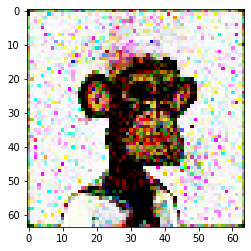

In [792]:
plt.imshow(  gen_imgs.data[4].permute(1, 2, 0)  )

In [793]:
generator.regularization(gen_imgs.data)

tensor(-2.9639, dtype=torch.float64)